Import des libraires

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob

# Import du jeu de données

In [2]:
files_to_load = glob.glob('../data/dvf*.csv')
dvf_raw = pd.concat([pd.read_csv(file,sep="|", decimal=',') for file in files_to_load])
df_reference_departement_raw = pd.read_csv("../data/departements-regions.csv",delimiter=",")

C:\Users\maelp\AppData\Local\Temp\ipykernel_2644\950919255.py:2: DtypeWarning: Columns (18,23,24,26,28,41) have mixed types. Specify dtype option on import or set low_memory=False.
  dvf_raw = pd.concat([pd.read_csv(file,sep="|", decimal=',') for file in files_to_load])


# purification des données

In [3]:
dvf_raw['Date mutation'] = pd.to_datetime(dvf_raw['Date mutation'], format='%d/%m/%Y')
dvf_raw['Nature mutation'] = dvf_raw['Nature mutation'].astype('category')

colonnes_a_garder = [
    'Date mutation', 
    'Nature mutation', 
    'Valeur fonciere',
    'Commune',
    'Code departement',
    'Surface terrain',
    'Surface reelle bati'
    ]

df_vf_raw = dvf_raw.drop(columns=[col for col in dvf_raw.columns if col not in colonnes_a_garder])
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('use_inf_as_na',True)

#On récupère que les ventes
df_vf_raw = df_vf_raw.loc[df_vf_raw['Nature mutation'] == 'Vente']

df_vf_raw.dropna(subset=['Valeur fonciere'], inplace=True)
df_vf_raw.dropna(subset=['Surface reelle bati'], inplace=True)

df_vf_raw['Valeur fonciere'] = df_vf_raw['Valeur fonciere'].astype('int64')
df_vf_raw['Surface reelle bati'] = df_vf_raw['Surface reelle bati'].astype('int64')

df_vf_raw['prix metre carre'] = df_vf_raw['Valeur fonciere'] / df_vf_raw['Surface reelle bati']
df_vf_raw.dropna(subset=['prix metre carre'], inplace=True)
df_vf_raw['prix metre carre'] = df_vf_raw['prix metre carre'].astype('int64')
print((df_vf_raw.isnull().mean() * 100).round(2))

Date mutation          0.00
Nature mutation        0.00
Valeur fonciere        0.00
Commune                0.00
Code departement       0.00
Surface reelle bati    0.00
Surface terrain       38.62
prix metre carre       0.00
dtype: float64


### Ajout d'un zéro dans le code département pour Merger

In [4]:
def updateCode(code : object) -> str:
    return str.zfill("{0}".format(code),2)

df_vf_raw['Code departement']=df_vf_raw['Code departement'].apply(updateCode)

df_dvf_region = df_vf_raw.merge(df_reference_departement_raw, how='left',left_on='Code departement', right_on='num_dep')

In [5]:
df_dvf_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257489 entries, 0 to 1257488
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Date mutation        1257489 non-null  datetime64[ns]
 1   Nature mutation      1257489 non-null  category      
 2   Valeur fonciere      1257489 non-null  int64         
 3   Commune              1257489 non-null  object        
 4   Code departement     1257489 non-null  object        
 5   Surface reelle bati  1257489 non-null  int64         
 6   Surface terrain      771890 non-null   float64       
 7   prix metre carre     1257489 non-null  int64         
 8   num_dep              1257489 non-null  object        
 9   dep_name             1257489 non-null  object        
 10  region_name          1257489 non-null  object        
dtypes: category(1), datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 97.1+ MB


# mise en forme des données

In [6]:
moyenne_prix_departement = df_dvf_region.groupby('Code departement')['prix metre carre'].mean()
nombre_vente_departement = df_dvf_region.groupby('Code departement')['Valeur fonciere'].count()
nom_departement = df_dvf_region.groupby('Code departement')['dep_name']

nombre_vente_region = df_dvf_region.groupby('region_name')['Valeur fonciere'].count()
nombre_vente_region = nombre_vente_region.reset_index()
nombre_vente_region.rename(columns={"Valeur fonciere": "nombre_vente"},inplace=True)

fusion = pd.merge(moyenne_prix_departement, nombre_vente_departement, left_index=True, right_index=True)
fusion = fusion.merge(df_reference_departement_raw, how='left',left_on='Code departement', right_on='num_dep')
fusion.rename(columns={"Valeur fonciere_x": "moyenne_prix", "Valeur fonciere": "nombre_vente","prix metre carre" : "moyenne_prix_metre_carre"},inplace=True)
fusion.reset_index(inplace=True)


# Affichage du résultat
#print(moyenne_prix_departement)
#print(nombre_vente_departement)
#print(nombre_vente_region)



# échantillonage des 5 premier et 5 dernier département par nombre de vente

In [7]:
colonne_tri = 'nombre_vente'
df_trie_asc_nombre_vente = fusion.sort_values(by=colonne_tri)[:5]
df_trie_desc_nombre_vente = fusion.sort_values(by=colonne_tri)[-5:]

print(df_trie_desc_nombre_vente)



    index  moyenne_prix_metre_carre  nombre_vente num_dep         dep_name   
66     66                  29860.14         38149      69            Rhône  \
33     33                  13043.62         39331      33          Gironde   
5       5                  14199.17         39748      06  Alpes-Maritimes   
72     72                  99637.70         48476      75            Paris   
58     58                  15052.96         51349      59             Nord   

                   region_name  
66        Auvergne-Rhône-Alpes  
33          Nouvelle-Aquitaine  
5   Provence-Alpes-Côte d'Azur  
72               Île-de-France  
58             Hauts-de-France  


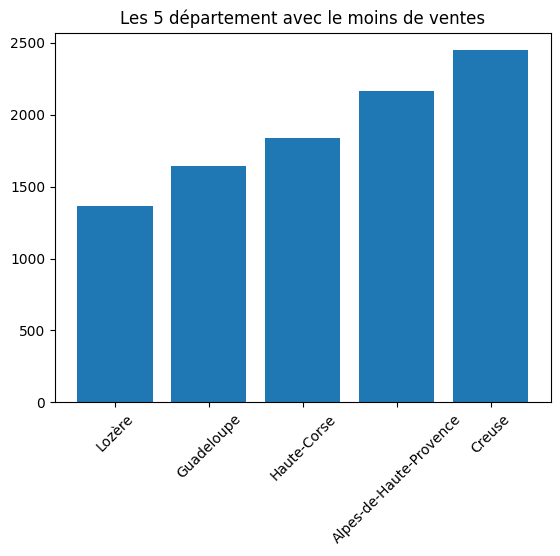

In [8]:
plt.bar(df_trie_asc_nombre_vente['dep_name'],df_trie_asc_nombre_vente['nombre_vente'])

# Ajouter un titre
plt.title('Les 5 département avec le moins de ventes')
# Afficher le diagramme
plt.xticks(rotation=45)
plt.show()

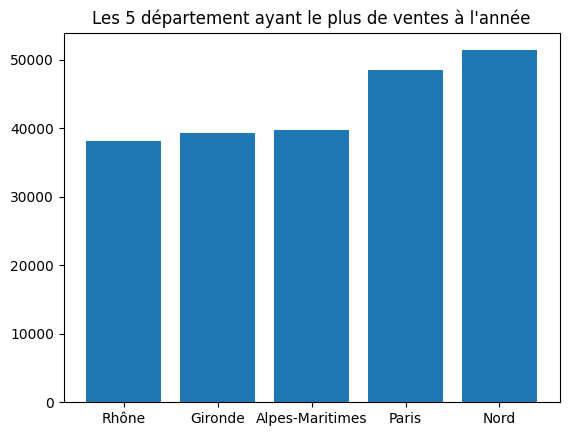

In [9]:
plt.bar(df_trie_desc_nombre_vente['dep_name'],df_trie_desc_nombre_vente['nombre_vente'])

# Ajouter un titre
plt.title('Les 5 département ayant le plus de ventes à l\'année')
# Afficher le diagramme
plt.show()

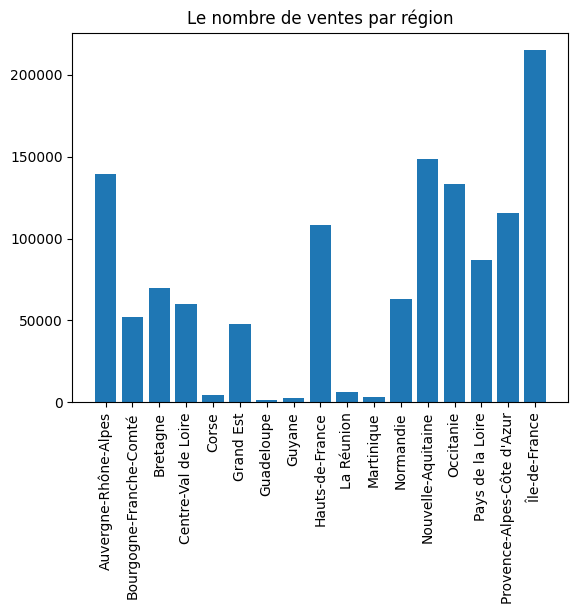

In [10]:
plt.bar(nombre_vente_region['region_name'],nombre_vente_region['nombre_vente'])

# Ajouter un titre
plt.title('Le nombre de ventes par région')
# Afficher le diagramme
plt.xticks(rotation=90)
plt.show()

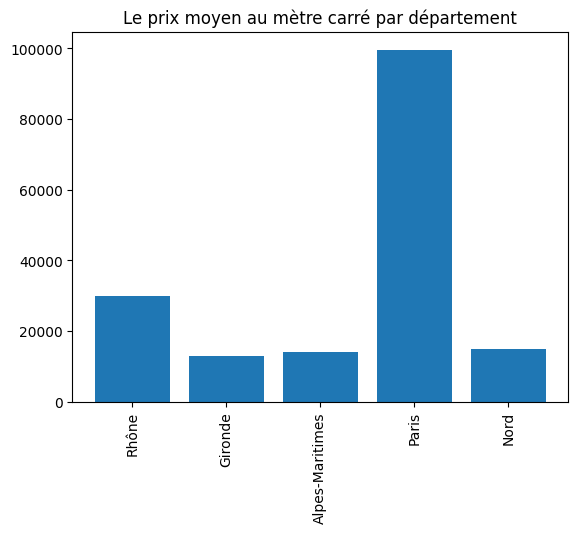

In [11]:
plt.bar(df_trie_desc_nombre_vente['dep_name'],df_trie_desc_nombre_vente['moyenne_prix_metre_carre'])

# Ajouter un titre
plt.title('Le prix moyen au mètre carré par département')
# Afficher le diagramme
plt.xticks(rotation=90)
plt.show()